# CO₂-Speicher-Tool (Jupyter-Notebook)

Dieses Notebook simuliert die CO₂-Einsparung durch Batteriespeicher anhand stündlicher Daten 
zum deutschen Strommix und Strompreisen. 

Alle Szenario-Parameter (Zeitraum, Batteriegröße, Nachfrage) können oben angepasst werden.


#  Schnellsteuerung & Zellennavigation 

Diese Übersicht zeigt, **wo** im Notebook welche Parameter angepasst werden:
Zellennummern beziehen sich auf dieses Notebook.

---

##  Zelle 4 – Setup & Szenario-Parameter (alles Wichtige zum Anpassen)
Hier steuerst du das gesamte Szenario.

**Dateipfade**
- `pfad_generation` → Pfad zur Erzeugungs-/CO₂-Intensitätsdatei
- `pfad_preise` → Pfad zur Preisdatei
> Anpassen, wenn sich Dateinamen/Orte ändern.

**Zeitraum**
- `period_start` / `period_end`
> Beispiel: Ganzes Jahr 2023 → `"2023-01-01"` bis `"2023-12-31 23:00"`.

**Nachfrage (falls kein Lastprofil gemerged wird)**
- `synthetic_demand_kwh_per_h`
> Konstante Nachfrage in kWh/h (z. B. 0.5 für Haushalt).  
> Bei **netzgekoppeltem Speicher** oft auf `0.0` setzen und stattdessen `limit_to_demand=False` (siehe Zelle 12).

**Batterie (BatteryConfig)**
- `capacity_kwh` → Energiespeichergröße [kWh], z. B. **710.0** (kommunaler Speicher)
- `p_charge_kw`, `p_discharge_kw` → Leistung [kW]  
  - **0,5 C** Empfehlung: bei 710 kWh ⇒ **355 kW**
  - **1 C** aggressiv: bei 710 kWh ⇒ **710 kW**
- `eta_roundtrip` → Wirkungsgrad (typ. 0.92)
- `soc_init_kwh` → Startfüllstand (Standard: 50 % der Kapazität)

**Strategie-Schwellen (Perzentile)**
- `low_pct`, `high_pct` (z. B. 0.30 / 0.70)  
  - 0.4 / 0.6 → empfindlicher (mehr Aktionen)  
  - 0.2 / 0.8 → selektiver (weniger Aktionen)

**Plot-Zeitraum (für Wochenplot)**
- `week_start`, `week_end` (z. B. `"2023-01-09"` bis `"2023-01-15"`)

---

##  Zelle 6 – Daten-Loader & Vorverarbeitung
Hier werden Dateien eingelesen, Spalten erkannt/vereinheitlicht und **Einheiten robust geprüft**.

- **Nur ändern, wenn**:
  - Spaltennamen in deinen Dateien anders heißen (z. B. „Datum von“, „CO2_g_per_kWh“, Preisspalte).
  - du das Parsing/Mapping an eigene Datenschemata anpassen willst.
- Was passiert:
  - Zahlenformate (deutsch) werden bereinigt.
  - Timestamps werden tolerant geparst.
  - `co2_intensity_g_per_kwh` wird erkannt/erzeugt; intern wird **kg/kWh** bereitgestellt.
  - Preise optional in `price_eur_mwh` und `price_eur_kwh`.
  - `demand_kwh` wird gesetzt (wenn nicht bereits vorhanden).

> **Hinweis**: Hier ist die Stelle, an der falsche Einheiten (g vs. kg vs. t) automatisch erkannt und korrigiert werden.

---

##  Zelle 8 – Batterie & Strategien (Code-Logik)
- **Battery**: SoC-Modell, Leistungsgrenzen, Wirkungsgrad.
- **CO₂-Strategie / Preis-Strategie**: Perzentil-basierte Regeln.
- **Normalerweise nichts ändern.**  
  Schwellenwerte kommen aus Zelle 4 (`low_pct`/`high_pct`).

---

##  Zelle 10 – Simulation (Referenz vs. mit Speicher)
- Führt die stündliche Simulation aus.
- Nutzt intern **kg/kWh** (Einheitencheck inklusive).
- **Parameter nicht hier**, sondern bei **Aufruf in Zelle 12** steuern (Strategie, Demand-Sicht).

---

##  Zelle 12 – Daten laden & Simulation starten (Startknopf)
Hier wird wirklich „gerechnet“.

- Daten zusammenführen:
  ```python
  df_gen   = load_generation_data(pfad_generation)
  df_price = load_price_data_de_lux(pfad_preise)
  df_in    = assemble_input(df_gen, df_price)
  df_sel   = df_in.loc[period_start:period_end].copy()



## Zelle 1 – Setup & Szenario-Parameter

Hier werden Bibliotheken geladen und alle Szenario-Parameter definiert.  
**Dynamisch anpassen:**
- Datenpfade zu CO₂- und Preisdaten
- Untersuchungszeitraum
- Nachfrageannahme (synthetisch oder Lastprofil)
- Batteriegröße und Leistung
- Strategie-Schwellen (Perzentile)
- Zeitfenster für Plots


In [1]:
# %% [markdown]
# # ⚙️ Setup & Szenario-Parameter
# Diese Zelle steuert das gesamte Szenario (Zeitraum, Speicher, Strategien, Sichtweise).
# -> Bei neuen Runs nur hier anpassen.

# %%
from __future__ import annotations
from dataclasses import dataclass
from typing import Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option("display.float_format", lambda x: f"{x:,.3f}")

# -----------------------------
# 🔁 Dateien (ANPASSEN)
# -----------------------------
# Erzeugung/CO₂ (mit Spalten 'Datum von' und 'CO2_g_per_kWh' ODER Sum_MWh / Sum_t_CO2)
pfad_generation = r"C:\Users\asus\Desktop\Masterarbeit\Realisierte Erzeugung\Strommix_mit_Emissionen_2325_EE_Tonnen (version 1).xlsx"
# Preise (mit Spalten 'Datum von' und 'Deutschland/Luxemburg [€/MWh]')
pfad_preise     = r"C:\Users\asus\Desktop\Masterarbeit\Strompreise\Gro_handelspreise_202301010000_202507010000_Stunde.csv"

# -----------------------------
# 📅 Untersuchungszeitraum (ANPASSEN)
# -----------------------------
period_start = "2023-01-01 00:00"
period_end   = "2023-12-31 23:00"

# -----------------------------
# 👥 Nachfrageannahme (ANPASSEN)
# -----------------------------
# Falls KEIN eigenes Lastprofil gemergt wird:
# - Prosumer-/Haushaltssicht: z.B. 0.5 kWh/h
# - Netzkoppelte Systemsicht (kommunaler Speicher): 0.0 kWh/h + limit_to_demand=False (siehe unten)
synthetic_demand_kwh_per_h = 22830 # Annahme Jahresverbrauch 200GWh/a -> Mittelwert pro Stunde 200 000 000/8760 =22830kWh/h

# -----------------------------
# 🔋 Batterieparameter (ANPASSEN)
# -----------------------------
@dataclass
class BatteryConfig:
    # Energiespeichergröße (Kapazität) in kWh
    capacity_kwh: float
    # Maximale Lade-/Entladeleistung in kW
    p_charge_kw: float
    p_discharge_kw: float
    # Rundtrip-Wirkungsgrad (0.92 = 92 %)
    eta_roundtrip: float = 0.92
    # Startfüllstand (kWh). None => 50 % der Kapazität (neutral, vermeidet Bias).
    # 0.0 => leer starten; capacity_kwh => voll starten.
    soc_init_kwh: Optional[float] = None

# Beispiel: Kommunaler Speicher 710 kWh, 0,5 C (≈ 355 kW)
bat_cfg = BatteryConfig(
    capacity_kwh   = 20_000.0, 
    p_charge_kw    = 10_000.0,   # 0.5 C
    p_discharge_kw = 10_000.0,   # 0.5 C
    eta_roundtrip  = 0.92,
    soc_init_kwh   = None     # None = 50 % Start-SoC (neutral)
)

# -----------------------------
# 🎯 Strategie-Schwellen (ANPASSEN)
# -----------------------------
# Perzentile für CO₂-/Preis-Strategie:
# 0.30/0.70 = robust (Standard), 0.40/0.60 = empfindlicher (mehr Aktionen), 0.20/0.80 = selektiver
low_pct, high_pct = 0.30, 0.70

# -----------------------------
# 🌐 Sichtweise (ANPASSEN)
# -----------------------------
# Prosumer-/Haushaltssicht: limit_to_demand = True  → Entladung max. = lokale Nachfrage
# System-/Netzsicht (kommunaler Speicher): limit_to_demand = False → Entladung netzseitig erlaubt
limit_to_demand = False

# -----------------------------
# 🗓️ Zeitfenster für Detail-Plot (ANPASSEN)
# -----------------------------
# Für Wochen-Detailplots; für Jahresplots werden separate Zellen mit Resampling genutzt.
week_start = "2023-01-07"
week_end   = "2023-01-14"


## Zelle 2 – Daten-Loader & Vorverarbeitung

Hier werden CO₂- und Preisdaten eingelesen und aufbereitet:
- Robust gegen deutsches Format (Tausenderpunkte, Komma als Dezimaltrenner).
- Zeitspalte „Datum von“ wird zum Index.
- CO₂-Intensität in g/kWh → kg/kWh.
- Preis in €/MWh → €/kWh.
- Nachfrage wird auf synthetischen Wert gesetzt (falls kein Lastprofil gemergt).

**Dynamisch anpassen:** Wenn ein Lastprofil vorliegt, hier statt `synthetic_demand_kwh_per_h` mergen.

#  Sichtweisen: Prosumer vs. System

Die Simulation kann in zwei unterschiedlichen Sichtweisen gefahren werden.  
Welche du wählst, hängt vom Anwendungsfall ab:

---

##  Prosumer-Sicht (Haushalt, Gewerbe, Industrie)
- Speicher hängt **hinter dem Zähler**.  
- Entladung darf **nie größer sein als die lokale Nachfrage**.  
- Typische Anwendung: Haushalt mit PV-Speicher, Industrie mit Lastmanagement.  

**Parameter:**
```python
synthetic_demand_kwh_per_h = 0.5     # Beispiel: 0.5 kWh/h konstante Nachfrage
limit_to_demand = True               # Entladung begrenzt auf lokale Nachfrage




In [2]:
def _to_float_series(s: pd.Series) -> pd.Series:
    if pd.api.types.is_numeric_dtype(s):
        return s.astype(float)
    return (
        s.astype(str)
         .str.replace(".", "", regex=False)
         .str.replace(",", ".", regex=False)
         .str.replace(r"[^0-9\.-]", "", regex=True)
         .replace("", np.nan)
         .astype(float)
    )

def load_generation_data(path: str) -> pd.DataFrame:
    p = Path(path)
    if p.suffix.lower() == ".csv":
        try:
            df = pd.read_csv(p, sep=";", decimal=",")
        except Exception:
            df = pd.read_csv(p)
    else:
        df = pd.read_excel(p)

    if "Datum von" not in df.columns:
        raise ValueError(f"Spalte 'Datum von' nicht gefunden. Spalten: {df.columns.tolist()}")
    if "CO2_g_per_kWh" not in df.columns:
        raise ValueError(f"Spalte 'CO2_g_per_kWh' nicht gefunden. Spalten: {df.columns.tolist()}")

    # --- Robustes Datums-Parsing für 'Datum von' ---
    # 1) Versuch: ISO/automatisch (passt für '2023-01-13 00:00:00')
    dts = pd.to_datetime(df["Datum von"], errors="coerce")

    # 2) Fallback: deutsches Format explizit (passt für '13.01.2023 00:00')
    mask = dts.isna()
    if mask.any():
        dts2 = pd.to_datetime(df.loc[mask, "Datum von"], format="%d.%m.%Y %H:%M", errors="coerce")
        dts.loc[mask] = dts2

    # 3) Notfalls: dayfirst=True als letzte Rettung (gemischte Fälle)
    mask = dts.isna()
    if mask.any():
        dts3 = pd.to_datetime(df.loc[mask, "Datum von"], dayfirst=True, errors="coerce")
        dts.loc[mask] = dts3

    # 4) Validierung
    if dts.isna().any():
        bad = df.loc[dts.isna(), "Datum von"].astype(str).head(5).tolist()
        raise ValueError(f"Datumsparsing fehlgeschlagen. Unlesbare Beispiele: {bad}")

    # Zeitindex setzen
    df = df.assign(**{"Datum von": dts}).set_index("Datum von").sort_index()

    # Nur die Spalten behalten, die wir brauchen
    out = pd.DataFrame(index=df.index)
    out["co2_intensity_g_per_kwh"] = _to_float_series(df["CO2_g_per_kWh"])
    out["demand_kwh"] = synthetic_demand_kwh_per_h
    return out



def load_price_data_de_lux(path: str) -> pd.DataFrame:
    """
    Liest DE/LU-Preisdaten mit 'Datum von' im deutschen Format (z. B. '13.01.2023 00:00')
    und einer Spalte mit Preisen in €/MWh (z. B. 'Deutschland/Luxemburg [€/MWh] ...').

    Parsingstrategie:
      1) format="%d.%m.%Y %H:%M"
      2) fallback: dayfirst=True
      3) Validierung: <=1% NaT erlaubt; ansonsten klare Fehlermeldung
    """
    p = Path(path)
    if p.suffix.lower() == ".csv":
        try:
            df = pd.read_csv(p, sep=";", decimal=",")
        except Exception:
            df = pd.read_csv(p)
    else:
        df = pd.read_excel(p)

    # Zeitspalte prüfen
    if "Datum von" not in df.columns:
        raise ValueError(f"'Datum von' fehlt in Preisdaten. Spalten: {df.columns.tolist()}")

    # Preisspalte finden
    price_cols = [c for c in df.columns if "Deutschland/Luxemburg" in c and "€" in c]
    if not price_cols:
        price_cols = [c for c in df.columns if "€/MWh" in c]
    if not price_cols:
        raise ValueError(f"Keine Preisspalte mit '€/MWh' gefunden. Spalten: {df.columns.tolist()}")
    price_col = price_cols[0]

    # 1) Deutsches Format explizit
    dts = pd.to_datetime(df["Datum von"], format="%d.%m.%Y %H:%M", errors="coerce")

    # 2) Fallback dayfirst=True (falls gemischt)
    if dts.isna().mean() > 0.01:
        dts = pd.to_datetime(df["Datum von"], dayfirst=True, errors="coerce")

    # 3) Validierung
    nat_rate = dts.isna().mean()
    if nat_rate > 0.01:
        sample_bad = df.loc[dts.isna(), "Datum von"].astype(str).head(5).tolist()
        raise ValueError(
            f"Datumsparsing fehlgeschlagen (NaT-Rate={nat_rate:.1%}). "
            f"Beispiele unlesbar: {sample_bad}. "
            f"Bitte prüfe Format (erwartet 'DD.MM.YYYY HH:MM')."
        )

    df = df.assign(**{"Datum von": dts}).dropna(subset=["Datum von"])
    df = df.set_index("Datum von").sort_index()
    df.index = df.index.floor("h")

    out = pd.DataFrame(index=df.index)
    out["price_eur_mwh"] = _to_float_series(df[price_col]).ffill()
    out = out[~out.index.duplicated(keep="last")]
    return out


def assemble_input(df_co2: pd.DataFrame, df_price: Optional[pd.DataFrame] = None) -> pd.DataFrame:
    df = df_co2.copy()
    if df_price is not None:
        df = df.merge(df_price, left_index=True, right_index=True, how="inner")
    return df

# --- Fix: Basis-Helper neu definieren (falls in dieser Sitzung fehlen) ---
import numpy as np
import pandas as pd

def ensure_time_index(df: pd.DataFrame) -> pd.DataFrame:
    """
    Sorgt für einen sortierten DatetimeIndex. Erlaubt entweder bereits vorhandenen
    DatetimeIndex oder eine Spalte 'timestamp' (alternativ 'Datum von', 'datetime', 'date', 'Zeit', 'Start').
    """
    out = df.copy()
    if isinstance(out.index, pd.DatetimeIndex):
        return out.sort_index()
    for c in ["timestamp", "Datum von", "datetime", "date", "Zeit", "Start"]:
        if c in out.columns:
            out[c] = pd.to_datetime(out[c])
            out = out.set_index(c)
            return out.sort_index()
    raise ValueError("Kein DatetimeIndex und keine geeignete Zeitspalte gefunden.")

def prepare_inputs(df: pd.DataFrame) -> pd.DataFrame:
    """
    Vereinheitlicht Einheiten und stellt Pflichtspalten bereit:
      - co2_intensity_g_per_kwh (Pflicht) -> co2_intensity_kg_per_kwh
      - price_eur_mwh (optional) -> price_eur_kwh
      - demand_kwh (optional; Default 0.0)
    """
    out = ensure_time_index(df).copy()

    if "co2_intensity_g_per_kwh" not in out.columns:
        raise ValueError("Spalte 'co2_intensity_g_per_kwh' fehlt.")

    # g/kWh -> kg/kWh
    out["co2_intensity_kg_per_kwh"] = out["co2_intensity_g_per_kwh"].astype(float) / 1000.0

    # Preise (optional)
    if "price_eur_mwh" in out.columns:
        out["price_eur_mwh"] = out["price_eur_mwh"].astype(float)
        out["price_eur_kwh"] = out["price_eur_mwh"] / 1000.0
    else:
        out["price_eur_mwh"] = np.nan
        out["price_eur_kwh"] = np.nan

    # Demand (optional)
    if "demand_kwh" in out.columns:
        out["demand_kwh"] = out["demand_kwh"].astype(float)
    else:
        out["demand_kwh"] = 0.0

    return out



## Zelle 3 – Batterie & Strategien

Hier wird das physikalische Batteriemodell definiert (SoC, Lade-/Entladeleistung, Wirkungsgrad).  
Außerdem: Strategien auf Basis von CO₂- und Preisschwellen (Perzentile).

**Dynamisch anpassen:** Schwellenwerte `low_pct`, `high_pct`.


In [3]:
class Battery:
    def __init__(self, cfg: BatteryConfig):
        self.cfg = cfg
        self.soc = cfg.capacity_kwh * 0.5 if cfg.soc_init_kwh is None else float(cfg.soc_init_kwh)
        self.soc = float(np.clip(self.soc, 0.0, cfg.capacity_kwh))

    def step_charge(self, dt_h: float = 1.0) -> float:
        headroom = self.cfg.capacity_kwh - self.soc
        ac_max_by_power = self.cfg.p_charge_kw * dt_h
        ac_max_by_headroom = headroom / self.cfg.eta_roundtrip
        return max(0.0, min(ac_max_by_power, ac_max_by_headroom))

    def step_discharge(self, dt_h: float = 1.0) -> float:
        ac_max_by_power = self.cfg.p_discharge_kw * dt_h
        ac_max_by_soc = self.soc * self.cfg.eta_roundtrip
        
        return max(0.0, min(ac_max_by_power, ac_max_by_soc))

    def apply_charge(self, e_ac_kwh: float):
        e_dc = e_ac_kwh * self.cfg.eta_roundtrip
        self.soc = float(np.clip(self.soc + e_dc, 0.0, self.cfg.capacity_kwh))

    def apply_discharge(self, e_ac_kwh: float):
        e_dc = e_ac_kwh / self.cfg.eta_roundtrip
        self.soc = float(np.clip(self.soc - e_dc, 0.0, self.cfg.capacity_kwh))

@dataclass
class CO2ThresholdParams:
    low_pct: float = low_pct
    high_pct: float = high_pct

class CO2ThresholdStrategy:
    def __init__(self, df: pd.DataFrame, params: CO2ThresholdParams):
        i = df["co2_intensity_kg_per_kwh"].values
        self.low_thr = float(np.nanpercentile(i, params.low_pct * 100))
        self.high_thr = float(np.nanpercentile(i, params.high_pct * 100))
        if not self.high_thr > self.low_thr:
            self.high_thr = self.low_thr + max(1e-6, 0.05 * self.low_thr)
    def decide(self, co2_kg_per_kwh: float) -> str:
        if co2_kg_per_kwh <= self.low_thr: return "charge"
        if co2_kg_per_kwh >= self.high_thr: return "discharge"
        return "idle"

@dataclass
class PriceThresholdParams:
    low_pct: float = low_pct
    high_pct: float = high_pct

class PriceThresholdStrategy:
    def __init__(self, df: pd.DataFrame, params: PriceThresholdParams):
        p = df["price_eur_mwh"].values
        self.low_thr = float(np.nanpercentile(p, params.low_pct * 100))
        self.high_thr = float(np.nanpercentile(p, params.high_pct * 100))
        if not self.high_thr > self.low_thr:
            self.high_thr = self.low_thr + max(1e-6, 0.05 * self.low_thr)
    def decide(self, price_eur_mwh: float) -> str:
        if price_eur_mwh <= self.low_thr: return "charge"
        if price_eur_mwh >= self.high_thr: return "discharge"
        return "idle"


## Zelle 4 – Simulation

Hier läuft die stündliche Simulation:
- Ohne Speicher (Referenz).
- Mit Speicher nach CO₂- oder Preis-Strategie.
- Ergebnisse: Emissionen, Einsparungen, Kosten.

**Dynamisch anpassen:** `limit_to_demand=True` → Prosumer-Sicht (Entladung nur bis Nachfrage).


In [4]:
@dataclass
class SimResult:
    df: pd.DataFrame
    total_em_ref_kg: float
    total_em_with_kg: float
    total_saving_kg: float
    total_saving_rel: float
    cost_ref_eur: Optional[float]
    cost_with_eur: Optional[float]
    cost_saving_eur: Optional[float]

def simulate(
    df_raw: pd.DataFrame,
    bat_cfg: BatteryConfig,
    strategy: str = "co2",
    co2_params: CO2ThresholdParams = CO2ThresholdParams(),
    price_params: PriceThresholdParams = PriceThresholdParams(),
    dt_h: float = 1.0,
    limit_to_demand: bool = True,
) -> SimResult:
    df = prepare_inputs(df_raw)
    strat = CO2ThresholdStrategy(df, co2_params) if strategy == "co2" else PriceThresholdStrategy(df, price_params)
    bat = Battery(bat_cfg)

    out = df.copy()

    # --- Sanity: notwendige Spalten ---
    if "co2_intensity_kg_per_kwh" not in out.columns and "co2_intensity_g_per_kwh" in out.columns:
        # Fallback: aus g/kWh in kg/kWh umrechnen
        out["co2_intensity_kg_per_kwh"] = out["co2_intensity_g_per_kwh"].astype(float) / 1000.0
    if "co2_intensity_kg_per_kwh" not in out.columns:
        raise ValueError("Spalte 'co2_intensity_kg_per_kwh' fehlt (nach prepare_inputs).")

    # --- Sanity: Wertebereich prüfen (typisch 0.2..0.9 kg/kWh). Wenn deutlich größer, dann wohl noch g/kWh. ---
    med = float(out["co2_intensity_kg_per_kwh"].median())
    if med > 2.0:  # z.B. 3.7 kg/kWh -> offensichtlich noch g/kWh
        # automatische Korrektur + Hinweisspalte
        out["co2_intensity_kg_per_kwh"] = out["co2_intensity_kg_per_kwh"] / 1000.0
        out["_auto_unit_fix_applied"] = True
    else:
        out["_auto_unit_fix_applied"] = False

    out["action"] = "idle"
    out["charge_kwh"] = 0.0
    out["discharge_kwh"] = 0.0
    # Referenz-Emissionen (kg) = kWh * kg/kWh
    out["em_ref_kg"] = out["demand_kwh"] * out["co2_intensity_kg_per_kwh"]

    for t, row in out.iterrows():
        decision = strat.decide(row["co2_intensity_kg_per_kwh"]) if strategy == "co2" else strat.decide(row["price_eur_mwh"])
        if decision == "charge":
            e_possible = bat.step_charge(dt_h)
            if e_possible > 0:
                bat.apply_charge(e_possible)
                out.at[t, "action"] = "charge"
                out.at[t, "charge_kwh"] = e_possible
        elif decision == "discharge":
            e_possible = bat.step_discharge(dt_h)
            if limit_to_demand:
                e_possible = min(e_possible, float(row["demand_kwh"]))
            if e_possible > 0:
                bat.apply_discharge(e_possible)
                out.at[t, "action"] = "discharge"
                out.at[t, "discharge_kwh"] = e_possible

    out["grid_import_with_kwh"] = (out["demand_kwh"] - out["discharge_kwh"] + out["charge_kwh"]).clip(lower=0.0)
    out["em_with_kg"] = out["grid_import_with_kwh"] * out["co2_intensity_kg_per_kwh"]

    total_em_ref = float(out["em_ref_kg"].sum())
    total_em_with = float(out["em_with_kg"].sum())
    total_saving = total_em_ref - total_em_with
    total_saving_rel = total_saving / total_em_ref if total_em_ref > 0 else np.nan

    if out["price_eur_kwh"].notna().any():
        out["cost_ref_eur"] = out["demand_kwh"] * out["price_eur_kwh"]
        out["cost_with_eur"] = out["grid_import_with_kwh"] * out["price_eur_kwh"]
        cost_ref = float(out["cost_ref_eur"].sum())
        cost_with = float(out["cost_with_eur"].sum())
        cost_saving = cost_ref - cost_with
    else:
        cost_ref = cost_with = cost_saving = None

    return SimResult(out, total_em_ref, total_em_with, total_saving, total_saving_rel, cost_ref, cost_with, cost_saving)


#  Simulation starten (Zelle 5)

In dieser Zelle wird die Simulation für den gewählten Zeitraum ausgeführt.

**Ablauf:**
1. **Datensatz laden und zusammenführen**
   - `df_gen`: Erzeugungs- und CO₂-Daten  
   - `df_price`: Strompreise  
   - `df_in`: Merge zu einer konsistenten Zeitreihe  
   - `df_sel`: Auswahl des Untersuchungszeitraums (per `period_start` / `period_end`)  

2. **Nachfrage setzen**
   - Falls kein Lastprofil vorhanden ist, wird ein synthetischer Wert (`synthetic_demand_kwh_per_h`) verwendet.  
   - Typische Szenarien:  
     - Haushalt: z. B. 0.5 kWh/h  
     - Kommunaler Speicher: 0.0 (→ reine Netzsicht, nur sinnvoll mit `limit_to_demand=False`)  

3. **Strategie-Parameter festlegen**
   - `co2_params`: Steuerung nach CO₂-Intensität (Perzentile `low_pct` / `high_pct`)  
   - `price_params`: Steuerung nach Preisen  

4. **Simulation starten**
   - `simulate(...)` wird zweimal aufgerufen:  
     - `res_co2` → Simulation nach CO₂-Strategie  
     - `res_price` → Simulation nach Preis-Strategie  
   - Beide Aufrufe enthalten `limit_to_demand=limit_to_demand`.  
     → dadurch wird die Sichtweise gesteuert:
       - `True` = Prosumer-Sicht (Speicher kann nur so viel entladen, wie Nachfrage da ist)  
       - `False` = System-/Netzsicht (Speicher kann unabhängig von lokaler Nachfrage entladen; typisch für kommunale Speicher oder PV-Großanlagen)  

**Hinweis:**  
Die tatsächliche Sichtweise wird oben in der Setup-Zelle (Parameterblock) gewählt:
```python
limit_to_demand = True   # Prosumer
# oder
limit_to_demand = False  # System



In [5]:
df_gen   = load_generation_data(pfad_generation)
df_price = load_price_data_de_lux(pfad_preise)
df_in    = assemble_input(df_gen, df_price)

df_sel = df_in.loc[period_start:period_end].copy()
df_sel["demand_kwh"] = synthetic_demand_kwh_per_h

co2_params   = CO2ThresholdParams(low_pct=low_pct, high_pct=high_pct)
price_params = PriceThresholdParams(low_pct=low_pct, high_pct=high_pct)

res_co2 = simulate(
    df_sel,
    bat_cfg,
    strategy="co2",
    co2_params=co2_params,
    limit_to_demand=limit_to_demand  
)
res_price = simulate(
    df_sel,
    bat_cfg,
    strategy="price",
    price_params=price_params,
    limit_to_demand=limit_to_demand  
)



#  Ergebnistabelle (Summary)

Diese Tabelle fasst die wichtigsten Kennzahlen der Simulation zusammen.

**Spalten:**
- `Szenario`  
  - Referenz (ohne Speicher) und Speicherbetrieb (CO₂- oder Preis-Strategie).  
- `Emissionen [kg CO₂]`  
  - Gesamtemissionen im Untersuchungszeitraum.  
  - Berechnet aus Nachfrage × CO₂-Intensität (kg/kWh).  
- `Einsparung [kg]`  
  - Absolute CO₂-Einsparung durch den Speicher im Vergleich zum Referenzfall.  
- `Einsparung [%]`  
  - Relative CO₂-Einsparung in Prozent.  
  - **Interpretation**: Gibt an, wie viel Prozent der Emissionen durch den Speicher vermieden wurden.  
- `Kosten [€]` *(falls Preisdaten vorliegen)*  
  - Stromkosten im Referenzfall und im Speicherbetrieb.  
  - Positive Differenz = Einsparung, negative Differenz = Mehrkosten.  

**Hinweise:**
- Die Größe der Einsparung hängt von:
  - Speichergröße (`capacity_kwh`) und Lade-/Entladeleistung (`p_charge_kw`, `p_discharge_kw`)  
  - Strategie-Schwellen (`low_pct`, `high_pct`)  
  - Sichtweise (`limit_to_demand`)  
  - CO₂-Intensität und Preisstruktur des gewählten Zeitraums  
- Bei `limit_to_demand=True` (Prosumer-Sicht) sind die Einsparungen typischerweise kleiner, da der Speicher nur den Eigenverbrauch beeinflusst.  
- Bei `limit_to_demand=False` (Systemsicht) können größere Einsparungen sichtbar werden, da der Speicher frei ins Netz wirkt.  



In [6]:
def summarize_result(res, strategy_name, bat_cfg) -> list[dict]:
    period = f"{res.df.index.min():%Y-%m-%d} – {res.df.index.max():%Y-%m-%d}"
    hours  = len(res.df)
    demand_sum = float(res.df["demand_kwh"].sum())
    ref = {
        "Zeitraum": period, "Stunden": hours,
        "Kapazität [kWh]": bat_cfg.capacity_kwh, "P_laden [kW]": bat_cfg.p_charge_kw,
        "P_entladen [kW]": bat_cfg.p_discharge_kw, "η_rt": bat_cfg.eta_roundtrip,
        "Strategie": f"{strategy_name} – Referenz",
        "Emissionen [kg CO₂]": res.total_em_ref_kg,
        "Einsparung [kg]": 0.0, "Einsparung [%]": 0.0,
        "Kosten [€]": res.cost_ref_eur if res.cost_ref_eur is not None else np.nan,
        "Nachfrage Σ [kWh]": demand_sum,
    }
    withs = ref.copy()
    withs.update({
        "Strategie": f"{strategy_name} – Mit Speicher",
        "Emissionen [kg CO₂]": res.total_em_with_kg,
        "Einsparung [kg]": res.total_saving_kg,
        "Einsparung [%]": 100*res.total_saving_rel if pd.notna(res.total_saving_rel) else np.nan,
        "Kosten [€]": res.cost_with_eur if res.cost_with_eur is not None else np.nan,
    })
    return [ref, withs]

rows = []
rows += summarize_result(res_co2, "CO₂", bat_cfg)
rows += summarize_result(res_price, "Preis", bat_cfg)

summary = pd.DataFrame(rows)
summary


,Zeitraum,Stunden,Kapazität [kWh],P_laden [kW],P_entladen [kW],η_rt,Strategie,Emissionen [kg CO₂],Einsparung [kg],Einsparung [%],Kosten [€],Nachfrage Σ [kWh]
0,2023-01-01 – 2023-12-31,8760,"20,000.000","10,000.000","10,000.000",0.920,CO₂ – Referenz,"68,548,620.473",0.000,0.000,"19,034,215.025","199,990,800.000"
1,2023-01-01 – 2023-12-31,8760,"20,000.000","10,000.000","10,000.000",0.920,CO₂ – Mit Speicher,"68,236,450.565","312,169.908",0.455,"18,949,486.310","199,990,800.000"
2,2023-01-01 – 2023-12-31,8760,"20,000.000","10,000.000","10,000.000",0.920,Preis – Referenz,"68,548,620.473",0.000,0.000,"19,034,215.025","199,990,800.000"
3,2023-01-01 – 2023-12-31,8760,"20,000.000","10,000.000","10,000.000",0.920,Preis – Mit Speicher,"68,313,318.055","235,302.418",0.343,"18,869,331.073","199,990,800.000"


In [7]:
print("Mean g/kWh   (aus df_sel):", df_sel["co2_intensity_g_per_kwh"].mean())
print("Mean kg/kWh? (aus df_sel/1000):", df_sel["co2_intensity_g_per_kwh"].mean()/1000)
print("Mean kg/kWh   (Spalte nach prepare):", df_sel.get("co2_intensity_kg_per_kwh", pd.Series(dtype=float)).mean())
print("Summe Nachfrage [kWh]:", df_sel["demand_kwh"].sum())
print("Analytische Ref [kg] ≈",
      df_sel["demand_kwh"].sum() * (
          df_sel["co2_intensity_kg_per_kwh"] 
          if "co2_intensity_kg_per_kwh" in df_sel.columns 
          else df_sel["co2_intensity_g_per_kwh"]/1000
      ).mean())


Mean g/kWh   (aus df_sel): 342.7588692739171
Mean kg/kWh? (aus df_sel/1000): 0.34275886927391713
Mean kg/kWh   (Spalte nach prepare): nan
Summe Nachfrage [kWh]: 199990800
Analytische Ref [kg] ≈ 68548620.47318612


## Zelle 7 – Aktionen-Log & Kurzsummary

Zeigt, wann der Speicher lädt/entlädt, und summiert Energiemengen sowie Anzahl der Lade-/Entladestunden.


In [8]:
log = res_co2.df[["co2_intensity_kg_per_kwh","demand_kwh","action","charge_kwh","discharge_kwh","grid_import_with_kwh"]].copy()
actions = log[log["action"] != "idle"].copy()

actions_summary = pd.DataFrame({
    "Ladestunden [h]": [(log["action"]=="charge").sum()],
    "Entladestunden [h]": [(log["action"]=="discharge").sum()],
    "Geladene Energie Σ [kWh]": [log["charge_kwh"].sum()],
    "Entladene Energie Σ [kWh]": [log["discharge_kwh"].sum()],
})

actions.head(10), actions_summary # nur die ersten 10 Zeilen der Datei
# .loc["2023-06-01"-"2023-06-07"] --> für einen bestimmten Zeitraum 



(                     co2_intensity_kg_per_kwh  demand_kwh     action  \
 Datum von                                                              
 2023-01-01 00:00:00                     0.169  22,830.000     charge   
 2023-01-01 01:00:00                     0.164  22,830.000     charge   
 2023-01-03 05:00:00                     0.437  22,830.000  discharge   
 2023-01-03 06:00:00                     0.455  22,830.000  discharge   
 2023-01-04 00:00:00                     0.227  22,830.000     charge   
 2023-01-04 01:00:00                     0.204  22,830.000     charge   
 2023-01-04 02:00:00                     0.201  22,830.000     charge   
 2023-01-05 21:00:00                     0.437  22,830.000  discharge   
 2023-01-05 22:00:00                     0.425  22,830.000  discharge   
 2023-01-07 12:00:00                     0.241  22,830.000     charge   
 
                      charge_kwh  discharge_kwh  grid_import_with_kwh  
 Datum von                                        

## Zelle 8 – Plots

Visualisierung für ein ausgewähltes Wochenfenster:
- Netzbezug mit/ohne Speicher.
- Lade-/Entlade-Energie als Balken.


In [9]:
print(res_co2.df["action"].value_counts())

action
idle         8318
charge        263
discharge     179
Name: count, dtype: int64


2023-01-01 00:00:00 <bound method Index.max of DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               ...
               '2023-03-31 14:00:00', '2023-03-31 15:00:00',
               '2023-03-31 16:00:00', '2023-03-31 17:00:00',
               '2023-03-31 18:00:00', '2023-03-31 19:00:00',
               '2023-03-31 20:00:00', '2023-03-31 21:00:00',
               '2023-03-31 22:00:00', '2023-03-31 23:00:00'],
              dtype='datetime64[ns]', name='Datum von', length=2159, freq=None)> 2159


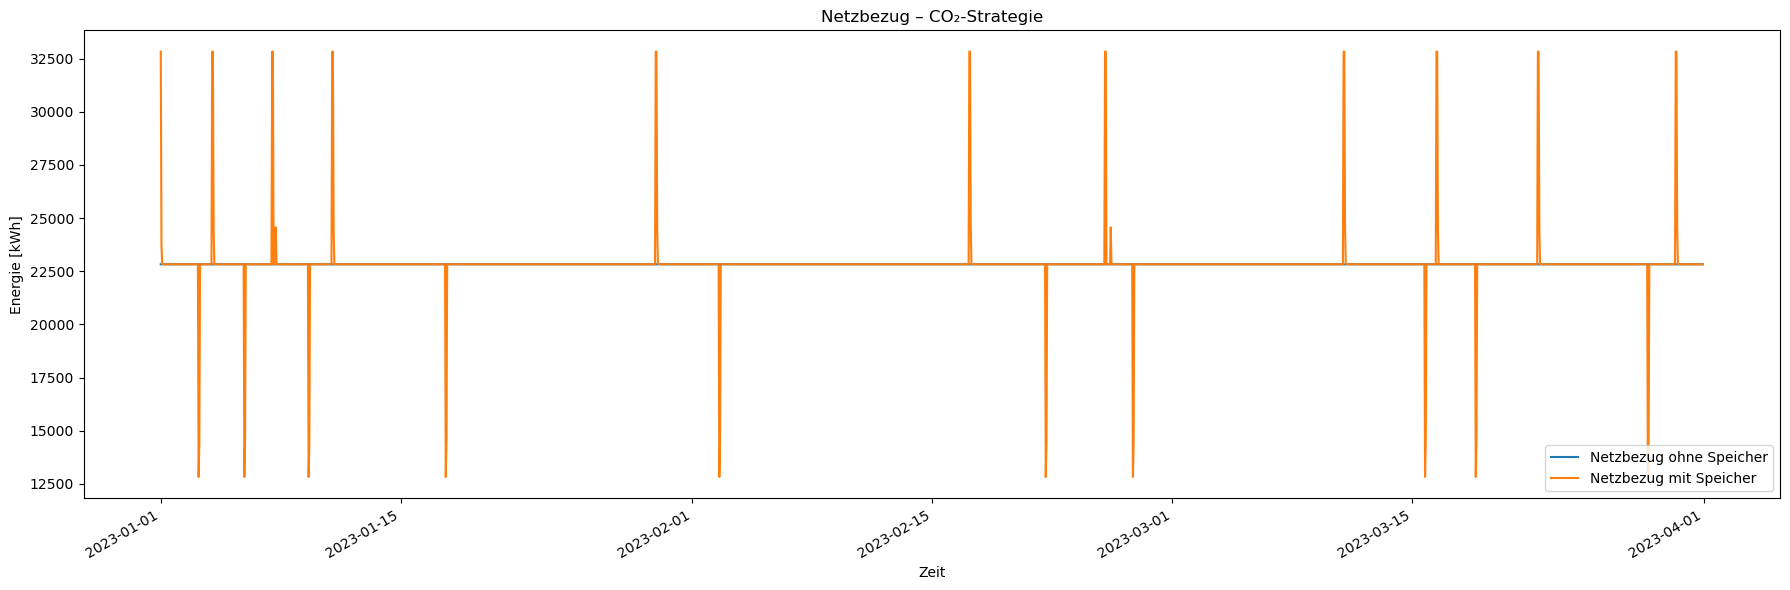

In [12]:
# --- Parameter für den Plot (anpassen) ---
# week_start = "2023-01-09"
# week_end   = "2023-01-15"

quarter_start = "2023-01-01"
quarter_end   = "2023-03-31"  

# Prüfen, dass res_co2 existiert:
assert 'res_co2' in globals(), "res_co2 fehlt – zuerst die Simulation ausführen."

# Wochenfenster auswählen
q = res_co2.df.loc[quarter_start:quarter_end].copy()
print(q.index.min(), q.index.max, len(q))


# Plot
ax = q[["demand_kwh", "grid_import_with_kwh"]].rename(columns={
    "demand_kwh": "Netzbezug ohne Speicher",
    "grid_import_with_kwh": "Netzbezug mit Speicher"
}).plot(figsize=(18, 6))  # <-- (Breite, Höhe) und Klammer zu

ax.set_title("Netzbezug – CO₂-Strategie")
ax.set_xlabel("Zeit")
ax.set_ylabel("Energie [kWh]")
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
print(res_co2.df[["co2_intensity_kg_per_kwh"]].loc["2023-01-09":"2023-01-15"].describe())